In [1]:
warnings('off')
library(ArchR)
set.seed(1)
setwd('/Users/gaozj/Documents/ArchR/')
addArchRThreads(threads = 16)

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Warning message:
“package ‘SummarizedExperiment’ was built under R version 4.0.3”
Loading required package: MatrixGenerics

Warning message:
“package ‘MatrixGenerics’ was built under R version 4.0.3”
Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, ro

In [2]:
inputFiles <- getTutorialData("Hematopoiesis")
inputFiles

addArchRGenome("hg19")

ArchR_example 
      "HemeFragments/ArchR_example.fragments.tsv.gz" 
                                      scATAC_BMMC_R1 
     "HemeFragments/scATAC_BMMC_R1.fragments.tsv.gz" 
                                 scATAC_CD34_BMMC_R1 
"HemeFragments/scATAC_CD34_BMMC_R1.fragments.tsv.gz" 
                                      scATAC_PBMC_R1 
     "HemeFragments/scATAC_PBMC_R1.fragments.tsv.gz"

Setting default genome to Hg19.



# Creating Arrow Files

In [4]:
ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles[2:4],
  sampleNames = names(inputFiles[2:4]),
  filterTSS = 4, #Dont set this too high because you can always increase later
  filterFrags = 1000,
  addTileMat = TRUE,
  addGeneScoreMat = TRUE
)

ArrowFiles

filterFrags is no longer a valid input. Please use minFrags! Setting filterFrags value to minFrags!

filterTSS is no longer a valid input. Please use minTSS! Setting filterTSS value to minTSS!

Using GeneAnnotation set by addArchRGenome(Hg19)!

Using GeneAnnotation set by addArchRGenome(Hg19)!

Warning message:
“package ‘BSgenome’ was built under R version 4.0.3”
Warning message:
“package ‘Biostrings’ was built under R version 4.0.3”
Warning message:
“package ‘XVector’ was built under R version 4.0.3”
Warning message:
“package ‘rtracklayer’ was built under R version 4.0.3”
ArchR logging to : ArchRLogs/ArchR-createArrows-57de7eb0c42b-Date-2024-03-08_Time-14-41-01.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2024-03-08 14:41:01 : Batch Execution w/ safelapply!, 0 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-createArrows-57de7eb0c42b-Date-2024-03-08_Time-14-41-01.log



[1] "scATAC_BMMC_R1.arrow"      "scATAC_CD34_BMMC_R1.arrow"
[3] "scATAC_PBMC_R1.arrow"

In [5]:
ArrowFiles

[1] "scATAC_BMMC_R1.arrow"      "scATAC_CD34_BMMC_R1.arrow"
[3] "scATAC_PBMC_R1.arrow"

# Inferring Doublets

In [6]:
doubScores <- addDoubletScores(
  input = ArrowFiles,
  k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
  knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search.
  LSIMethod = 1
)

proj <- ArchRProject(
  ArrowFiles = ArrowFiles,
  outputDirectory = "HemeTutorial",
  copyArrows = TRUE #This is recommened so that you maintain an unaltered copy for later usage.
)

getAvailableMatrices(proj)
proj <- filterDoublets(ArchRProj = proj)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-57de71f2408-Date-2024-03-08_Time-14-43-46.log
If there is an issue, please report to github with logFile!

2024-03-08 14:43:46 : Batch Execution w/ safelapply!, 0 mins elapsed.

2024-03-08 14:43:46 : scATAC_BMMC_R1 (1 of 3) :  Computing Doublet Statistics, 0 mins elapsed.

Warning message:
“The following arguments are not used: row.names”
scATAC_BMMC_R1 (1 of 3) : UMAP Projection R^2 = 0.98911

scATAC_BMMC_R1 (1 of 3) : UMAP Projection R^2 = 0.98911

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2024-03-08 14:46:05 : scATAC_CD34_BMMC_R1 (2 of 3) :  Computing Doublet Statistics, 2.317 mins elapsed.

Warning message:
“The following arguments are not used: row.names”
scATAC_CD34_BMMC_R1 (2 of 3) : UMAP Projection R^2 = 0.98934

scATAC_CD34_BMMC_R1 (2 of 3) : UMAP Projection R^2 = 0.98934

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "n

[1] "GeneScoreMatrix" "TileMatrix"

Filtering 410 cells from ArchRProject!

	scATAC_BMMC_R1 : 243 of 4932 (4.9%)

	scATAC_CD34_BMMC_R1 : 107 of 3275 (3.3%)

	scATAC_PBMC_R1 : 60 of 2453 (2.4%)



# Dimensionality Reduction and Clustering

In [7]:
# get the genomic bins for dimensionality reduction
set.seed(1)
proj <- addIterativeLSI(ArchRProj = proj, useMatrix = "TileMatrix", name = "IterativeLSI")
bedcontent <- proj@reducedDims$IterativeLSI$LSIFeatures
tilemat <- getMatrixFromProject(proj,useMatrix = 'TileMatrix',binarize = TRUE)

tilemat.assay <- tilemat@assays
tilemat.value <- getListElement(tilemat.assay,'TileMatrix')

seqname <- bedcontent[1]
start <- bedcontent[4]
end <- start$start + 500

padding <- rep(c('.','.','.'),dim(bedcontent)[1])
padding <- matrix(padding,nrow=dim(bedcontent)[1],byrow=TRUE)
bedcontent <- cbind(seqname,start,end,padding)

write.table(bedcontent,'ArchR.bed',sep = '\t',col.names = FALSE,quote =FALSE,row.names = FALSE)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-288840f982c7-Date-2023-12-28_Time-10-51-57.log
If there is an issue, please report to github with logFile!

2023-12-28 10:51:58 : Computing Total Across All Features, 0.002 mins elapsed.

2023-12-28 10:51:59 : Computing Top Features, 0.023 mins elapsed.

###########
2023-12-28 10:52:00 : Running LSI (1 of 2) on Top Features, 0.035 mins elapsed.
###########

2023-12-28 10:52:00 : Sampling Cells (N = 10001) for Estimated LSI, 0.036 mins elapsed.

2023-12-28 10:52:00 : Creating Sampled Partial Matrix, 0.036 mins elapsed.

2023-12-28 10:52:03 : Computing Estimated LSI (projectAll = FALSE), 0.095 mins elapsed.

2023-12-28 10:52:22 : Identifying Clusters, 0.417 mins elapsed.

Warning message:
“The following arguments are not used: row.names”
2023-12-28 10:52:39 : Identified 6 Clusters, 0.7 mins elapsed.

2023-12-28 10:52:39 : Saving LSI Iteration, 0.7 mins elapsed.

2023-12-28 10:52:51 : Creating Cluster Matrix on the tot

# Reference method (refProj)

In [6]:
library(OpenAnnotateR)
input <- "ArchR.bed"
taskid <- runAnnotate(input, 1, 1, 1)
getProgress(taskid)


Attaching package: ‘OpenAnnotateR’


The following object is masked from ‘package:utils’:

    help




[1] "your task id is : 2022092210512621"
[1] "You can get the progress of your task through getProgress(task_id=2022092210512621)"
[1] "Your task has been completed!"
[1] "You can get the result file type first through getResultList()"
[1] "You can download result file through getAnnoResult(result_type,cell_type, 2022092210512621)"


In [ ]:
getAnnoResult(3,1,taskid)

In [8]:
# Perform TF-IDF (count_mat: peak*cell)
tfidf1=function(count_mat){
    nfreqs <- 1.0 * count_mat / matrix(rep(colSums(count_mat),dim(count_mat)[1]),byrow = T,nrow=dim(count_mat)[1])
    tfidf_mat <- nfreqs * matrix(rep(log(1 + 1.0 * dim(count_mat)[2] / (1e-5+rowSums(count_mat))),dim(count_mat)[2]),byrow = F,ncol=dim(count_mat)[2])
    return(tfidf_mat)
}

In [9]:
dim(as.matrix(tilemat.value[proj@reducedDims$IterativeLSI$LSIFeatures$idx,]))

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.9 GiB”


[1] 25000 10250

# Dimensionality reduction

In [10]:
library(MASS)
peakopen <- read.table('./results/2022091211044419_peakopen.txt.gz',header = FALSE)
peakopen <- peakopen[,5:dim(peakopen)[2]]
peakopen.pca <- prcomp(t(peakopen),rank=30)

readopen <- read.table('./results/2022091211044419_readopen.txt.gz',header = FALSE)
readopen <- readopen[,5:dim(readopen)[2]]
readopen.pca <- prcomp(t(readopen),rank=30)

sc_conuts.mat <- as.matrix(tilemat.value[proj@reducedDims$IterativeLSI$LSIFeatures$idx,])
sc_conuts.mat <- t(tfidf1(sc_conuts.mat))

norm.embeddings_peak <- sc_conuts.mat %*% peakopen.pca$rotation
norm.embeddings_read <- sc_conuts.mat %*% readopen.pca$rotation

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 1.9 GiB”


In [11]:
# create the dimentionality reduction result with refProj
col_name <- c()
for(j in 1:30)
{
 col_name <- c(col_name,paste('LSI',as.character(j+30)))   
}
colnames(norm.embeddings_peak) <- col_name
rownames(norm.embeddings_peak) <- rownames(proj@reducedDims$IterativeLSI$matSVD)

col_name <- c()
for(j in 1:30)
{
 col_name <- c(col_name,paste('LSI',as.character(j+60)))   
}
norm.embeddings_read <- matrix(norm.embeddings_read,nrow = 10250)
colnames(norm.embeddings_read) <- col_name
rownames(norm.embeddings_read) <- rownames(proj@reducedDims$IterativeLSI$matSVD)

In [12]:
# Create the ArchRProject with the result of refProj
proj_ref <- proj
proj_ref <- addIterativeLSI(ArchRProj = proj_ref, useMatrix = "TileMatrix", name = "Reference")
norm.embeddings <- cbind(scale(proj_ref@reducedDims$IterativeLSI$matSVD[,1:30]),scale(norm.embeddings_read)[,1:10])
proj_ref@reducedDims$Reference$matSVD <- norm.embeddings_read

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-288861e57432-Date-2023-12-28_Time-10-56-34.log
If there is an issue, please report to github with logFile!

2023-12-28 10:56:34 : Computing Total Across All Features, 0.003 mins elapsed.

2023-12-28 10:56:35 : Computing Top Features, 0.019 mins elapsed.

###########
2023-12-28 10:56:36 : Running LSI (1 of 2) on Top Features, 0.036 mins elapsed.
###########

2023-12-28 10:56:36 : Sampling Cells (N = 10001) for Estimated LSI, 0.038 mins elapsed.

2023-12-28 10:56:36 : Creating Sampled Partial Matrix, 0.038 mins elapsed.

2023-12-28 10:56:40 : Computing Estimated LSI (projectAll = FALSE), 0.094 mins elapsed.

2023-12-28 10:56:59 : Identifying Clusters, 0.41 mins elapsed.

Warning message:
“The following arguments are not used: row.names”
2023-12-28 10:57:16 : Identified 6 Clusters, 0.694 mins elapsed.

2023-12-28 10:57:16 : Saving LSI Iteration, 0.694 mins elapsed.

2023-12-28 10:57:28 : Creating Cluster Matrix on the 

## Clustering performance with ArchR

ArchR logging to : ArchRLogs/ArchR-addClusters-288817b38c4d-Date-2023-12-28_Time-11-01-48.log
If there is an issue, please report to github with logFile!

Overriding previous entry for Clusters

2023-12-28 11:01:48 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.001 mins elapsed.

Warning message:
“The following arguments are not used: row.names”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10250
Number of edges: 464385

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8653
Number of communities: 12
Elapsed time: 0 seconds


2023-12-28 11:02:05 : Testing Outlier Clusters, 0.283 mins elapsed.

2023-12-28 11:02:05 : Assigning Cluster Names to 12 Clusters, 0.283 mins elapsed.

2023-12-28 11:02:05 : Finished addClusters, 0.283 mins elapsed.

11:02:05 UMAP embedding parameters a = 0.7669 b = 1.223

11:02:05 Read 10250 rows and found 30 numeric columns

11:02:05 Using Annoy for neighbor search, n_neighbors = 40

11:02:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

11:02:06 Writing NN index file to temp file /var/folders/99/vgtbqjkd7rs8m03kzbjw_rfm0000gn/T//RtmpU4Zi37/file2888cc01f63

11:02:06 Searching Annoy index using 4 threads, search_k = 4000

11:02:07 Annoy recall = 100%

11:02:07 Commencing smooth kNN distance calibration using 4 threads
 with target n_neighbors = 40

11:02:08 Initiali

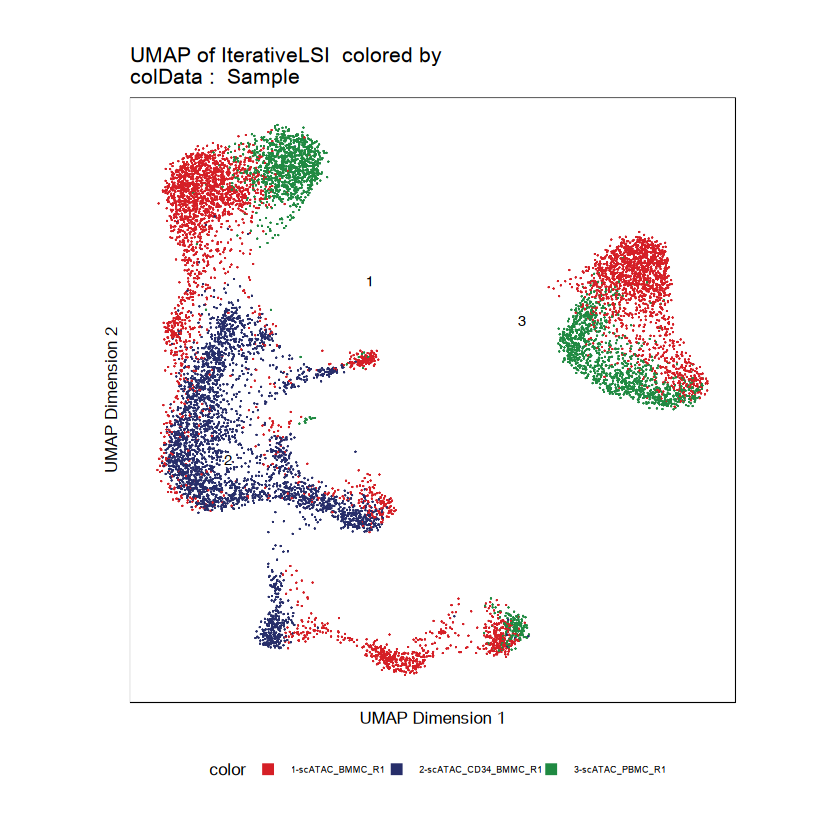

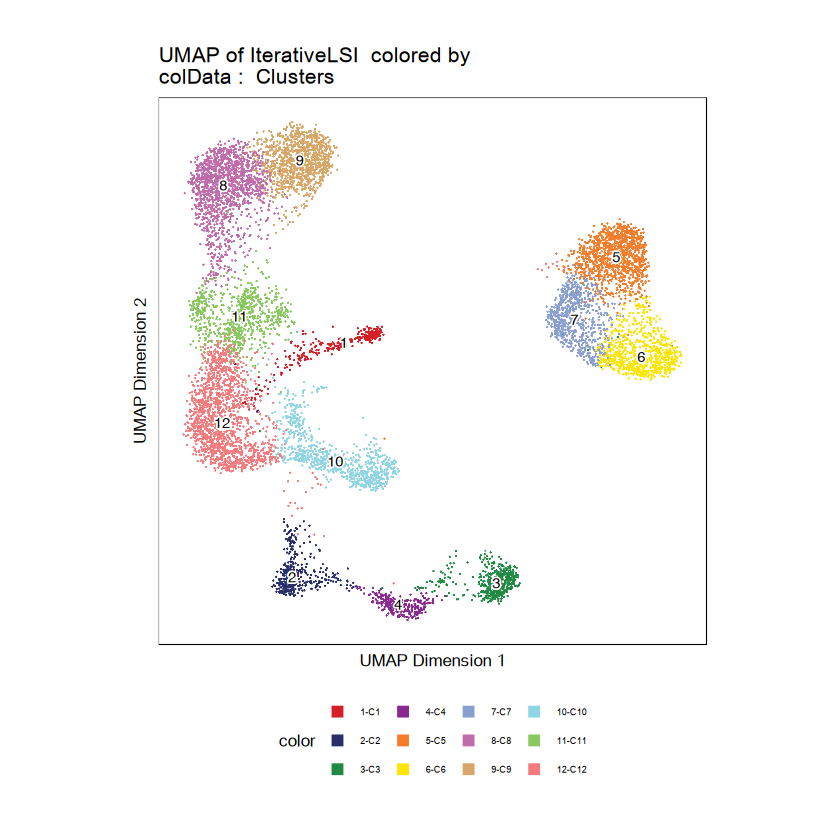

In [22]:
proj <- addClusters(input = proj, reducedDims = "IterativeLSI",force = TRUE)
proj <- addUMAP(ArchRProj = proj, reducedDims = "IterativeLSI",force = TRUE)
p1 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Sample", embedding = "UMAP")
p2 <- plotEmbedding(ArchRProj = proj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")
p1
p2

In [23]:
ggsave(p1, filename = "plot_orgin_p1_1228.png", width = 8, height = 6,dpi = 450)
ggsave(p2, filename = "plot_orgin_p2_1228.png", width = 8, height = 6,dpi = 450)

In [3]:
library(cluster)
library(fpc)
# origin
clusters <- lapply(proj$Clusters,function(x){return(as.numeric(substring(x,2)))})
stats <- cluster.stats(dist(proj@embeddings$UMAP$df), as.numeric(clusters))
print(c(stats$avg.silwidth,stats$ch))

[1] 4.950242e-01 2.938703e+04


In [15]:
rowZscores <- function(m = NULL, min = -2, max = 2, limit = FALSE){
  z <- sweep(m - rowMeans(m), 1, matrixStats::rowSds(m),`/`)
  if(limit){
    z[z > max] <- max
    z[z < min] <- min
  }
  return(z)
}
scaleDims <- function(x, scaleMax = NULL){
  if(!is.null(scaleMax)){
    rowZscores(m=x, min=-scaleMax, max = scaleMax, limit = TRUE)
  }else{
    rowZscores(m=x)
  }
}

## Clustering performance with refProj

ArchR logging to : ArchRLogs/ArchR-addClusters-2888277ca0f1-Date-2023-12-28_Time-10-59-38.log
If there is an issue, please report to github with logFile!

Filtering 10 dims correlated > 0.75 to log10(depth + 1)

2023-12-28 10:59:38 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.001 mins elapsed.

Warning message:
“The following arguments are not used: row.names”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10250
Number of edges: 459545

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8664
Number of communities: 12
Elapsed time: 0 seconds


2023-12-28 10:59:55 : Testing Outlier Clusters, 0.284 mins elapsed.

2023-12-28 10:59:55 : Assigning Cluster Names to 12 Clusters, 0.286 mins elapsed.

2023-12-28 10:59:55 : Finished addClusters, 0.287 mins elapsed.

Filtering 10 dims correlated > 0.75 to log10(depth + 1)

10:59:55 UMAP embedding parameters a = 0.7669 b = 1.223

10:59:55 Read 10250 rows and found 30 numeric columns

10:59:55 Using Annoy for neighbor search, n_neighbors = 40

10:59:55 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:59:56 Writing NN index file to temp file /var/folders/99/vgtbqjkd7rs8m03kzbjw_rfm0000gn/T//RtmpU4Zi37/file2888672a4277

10:59:56 Searching Annoy index using 4 threads, search_k = 4000

10:59:56 Annoy recall = 100%

10:59:57 Commencing smooth kNN distance calibration using 

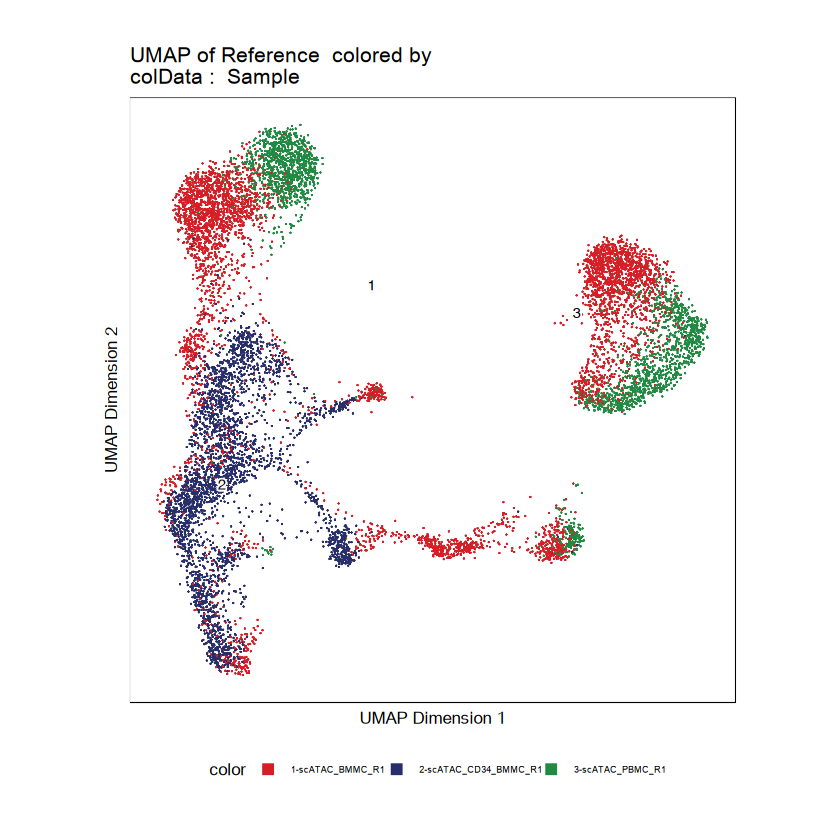

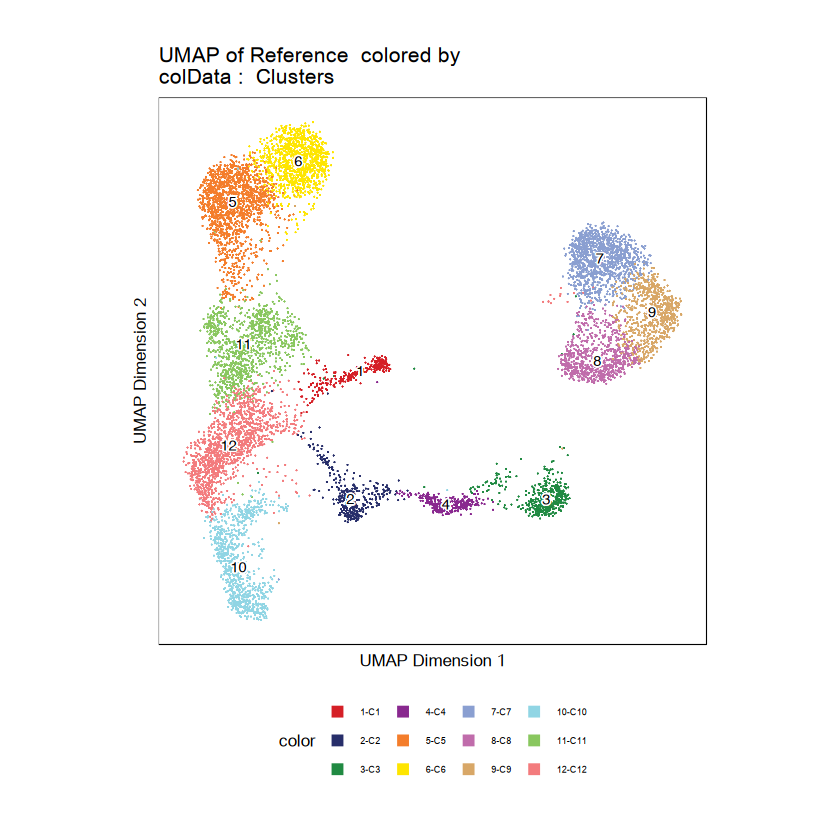

In [16]:
# reference method to reduce dim with max clusters 12
norm.embeddings <- cbind(proj_ref@reducedDims$IterativeLSI$matSVD[,1:30],scaleDims(norm.embeddings_read)[,1:10])
proj_ref@reducedDims$Reference$matSVD <- norm.embeddings
proj_ref <- addClusters(input = proj_ref, reducedDims = "Reference",force = TRUE,dimsToUse=1:40,scaleDims=TRUE)
proj_ref <- addUMAP(ArchRProj = proj_ref, reducedDims = "Reference",force = TRUE,dimsToUse=1:40,scaleDims=TRUE)
p1 <- plotEmbedding(ArchRProj = proj_ref, colorBy = "cellColData", name = "Sample", embedding = "UMAP")
p2 <- plotEmbedding(ArchRProj = proj_ref, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")
p1
p2

In [6]:
# reference
library(cluster)
library(fpc)
clusters <- lapply(proj_ref$Clusters,function(x){return(as.numeric(substring(x,2)))})
stats <- cluster.stats(dist(proj_ref@embeddings$UMAP$df), as.numeric(clusters))
stats$avg.silwidth

[1] 0.5047451

In [7]:
print(c(stats$avg.silwidth,stats$ch))

[1] 5.047451e-01 2.945909e+04


# Assigning Clusters with Gene Scores

In [25]:
proj <- addImputeWeights(proj)
proj_ref <- addImputeWeights(proj_ref)

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-2888430bf4bc-Date-2023-12-28_Time-11-03-52.log
If there is an issue, please report to github with logFile!

2023-12-28 11:03:52 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-288845f08507-Date-2023-12-28_Time-11-03-59.log
If there is an issue, please report to github with logFile!

2023-12-28 11:03:59 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.



In [26]:
markerGenes  <- c(
    "CD34",  #Early Progenitor
    "GATA1", #Erythroid
    "PAX5", "MS4A1", "MME", #B-Cell Trajectory
    "CD14", "MPO", #Monocytes
    "CD3D", "CD8A"#TCells
  )

p <- plotEmbedding(
    ArchRProj = proj, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(proj)
)

p_ref <- plotEmbedding(
    ArchRProj = proj_ref, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(proj_ref)
)

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-288831adb270-Date-2023-12-28_Time-11-04-06.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2023-12-28 11:04:06 : 



Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 
8 
9 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-288831adb270-Date-2023-12-28_Time-11-04-06.log

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-288829df08b-Date-2023-12-28_Time-11-04-11.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2023-12-28 11:04:11 : 



Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 
8 
9 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-288829df08b-Date-2023-12-28_Time-11-04-11.l

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


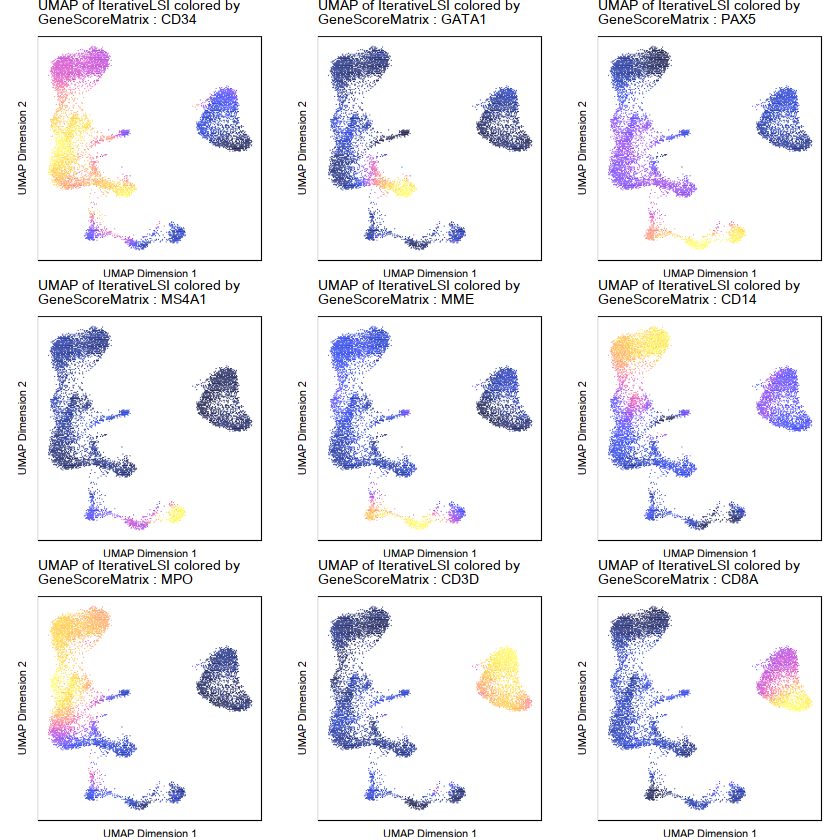

In [27]:
#Rearrange for grid plotting
p2 <- lapply(p, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p2))

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


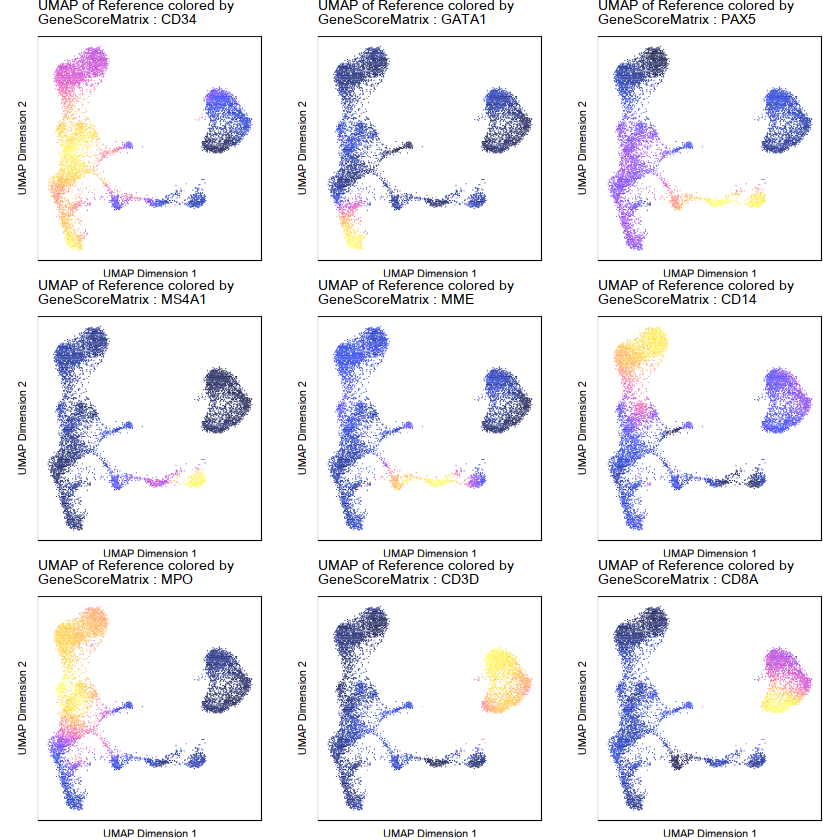

In [28]:
p2_ref <- lapply(p_ref, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p2_ref))

# Visualizing Genome Browser Tracks

In addition to plotting gene scores per cell as a UMAP overlay, we can browse the local chromatin accessibility at these marker genes on a per cluster basis with genome browser tracks. To do this, we use the plotBrowserTrack() function which will create a list of plots, one for each of the genes specified by markerGenes

In [31]:
p <- plotBrowserTrack(
    ArchRProj = proj, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-288866aa3f62-Date-2023-12-28_Time-11-04-42.log
If there is an issue, please report to github with logFile!

2023-12-28 11:04:42 : Validating Region, 0.002 mins elapsed.



GRanges object with 9 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]     chr1 208059883-208084683      - |         947        CD34
  [2]     chrX   48644982-48652717      + |        2623       GATA1
  [3]     chr9   36838531-37034476      - |        5079        PAX5
  [4]    chr11   60223282-60238225      + |         931       MS4A1
  [5]     chr3 154741913-154901518      + |        4311         MME
  [6]     chr5 140011313-140013286      - |         929        CD14
  [7]    chr17   56347217-56358296      - |        4353         MPO
  [8]    chr11 118209789-118213459      - |         915        CD3D
  [9]     chr2   87011728-87035519      - |         925        CD8A
  -------
  seqinfo: 24 sequences from hg19 genome


2023-12-28 11:04:43 : Adding Bulk Tracks (1 of 9), 0.003 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2023-12-28 11:04:43 : Adding Gene Tracks (1 of 9), 0.012 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2023-12-28 11:04:43 : Plotting, 0.014 mins elapsed.

2023-12-28 11:04:44 : Adding Bulk Tracks (2 of 9), 0.029 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2023-12-28 11:04:44 : Adding Gene Tracks (2 of 9), 0.035 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2023-12-28 11:04:45 : Plotting, 0.038 mins elapsed.

2023-12-28 11:04:45 : Adding Bulk Tracks (3 of 9), 0.05 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


In [32]:
ggsave(p$CD14, filename = "plot_geneCD14_origin_p1_1228.png", width = 8, height = 6,dpi = 450)


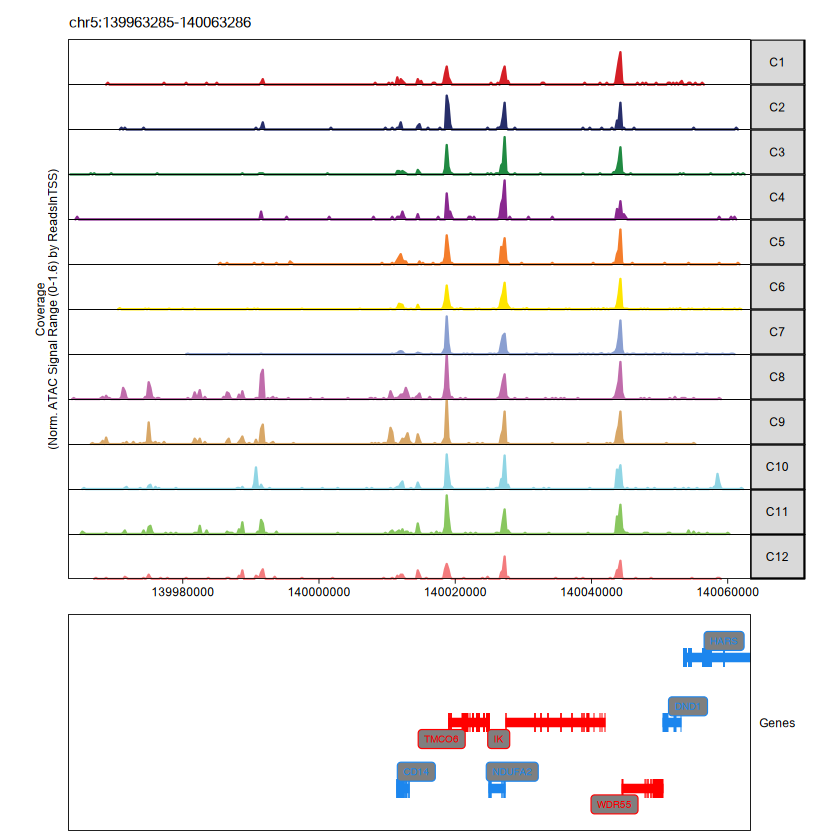

In [33]:
grid::grid.newpage()
grid::grid.draw(p$CD14)

In [34]:
p_ref <- plotBrowserTrack(
    ArchRProj = proj_ref, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-2888620efb16-Date-2023-12-28_Time-11-04-56.log
If there is an issue, please report to github with logFile!

2023-12-28 11:04:56 : Validating Region, 0.001 mins elapsed.



GRanges object with 9 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]     chr1 208059883-208084683      - |         947        CD34
  [2]     chrX   48644982-48652717      + |        2623       GATA1
  [3]     chr9   36838531-37034476      - |        5079        PAX5
  [4]    chr11   60223282-60238225      + |         931       MS4A1
  [5]     chr3 154741913-154901518      + |        4311         MME
  [6]     chr5 140011313-140013286      - |         929        CD14
  [7]    chr17   56347217-56358296      - |        4353         MPO
  [8]    chr11 118209789-118213459      - |         915        CD3D
  [9]     chr2   87011728-87035519      - |         925        CD8A
  -------
  seqinfo: 24 sequences from hg19 genome


2023-12-28 11:04:56 : Adding Bulk Tracks (1 of 9), 0.001 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2023-12-28 11:04:57 : Adding Gene Tracks (1 of 9), 0.009 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2023-12-28 11:04:57 : Plotting, 0.013 mins elapsed.

2023-12-28 11:04:58 : Adding Bulk Tracks (2 of 9), 0.027 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2023-12-28 11:04:58 : Adding Gene Tracks (2 of 9), 0.034 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2023-12-28 11:04:59 : Plotting, 0.036 mins elapsed.

2023-12-28 11:04:59 : Adding Bulk Tracks (3 of 9), 0.048 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”

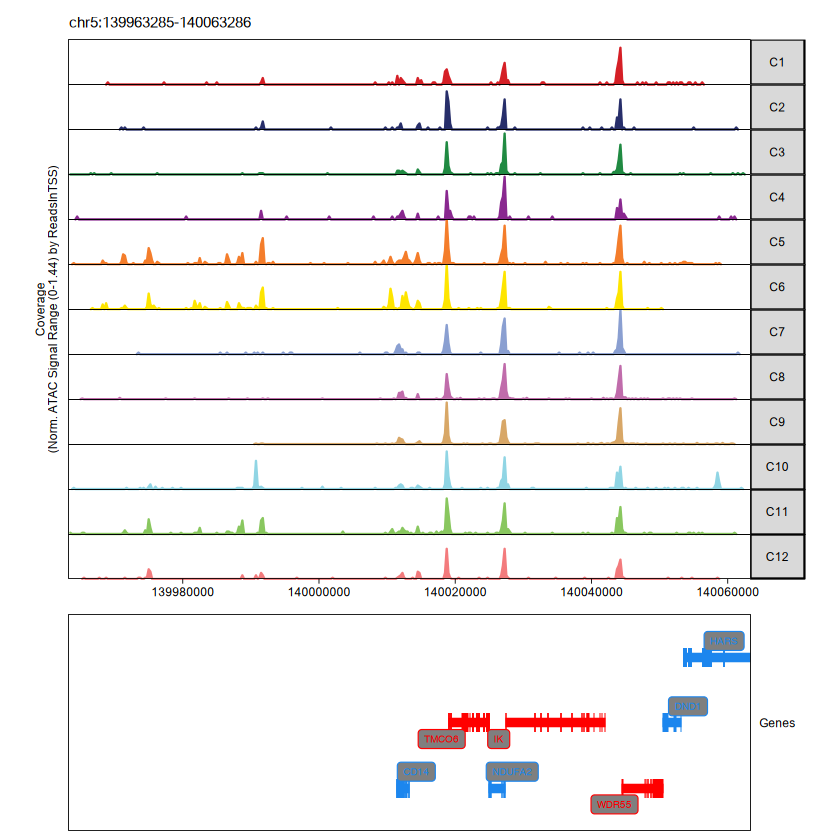

In [35]:
grid::grid.newpage()
grid::grid.draw(p_ref$CD14)